In [2]:
import json
import re
import numpy as np

def gen_plot(ans, predict_per_item, labels_json, partition):
    logits = {}
    all_data = {}

    class_names = labels_json['class_names']

    for fn in labels_json['splits'][partition]:
        all_data[fn] = labels_json['labels'][fn]

    is_frame_level = predict_per_item > 1
    assert predict_per_item % 2 == 0

    if is_frame_level:
        tmp = np.linspace(0.4, 0.6, predict_per_item // 2)
        window = np.concatenate([tmp, np.flip(tmp)])[:, None]
    else:
        tmp = np.linspace(0, 1, predict_per_item // 2)
        window = np.concatenate([tmp, np.flip(tmp)])[:, None]

    for k in all_data.keys():
        logits[k] = np.zeros((len(all_data[k]), len(class_names)))

    for el in ans:
        name = el[0]
        preds = np.array(el[1])
        if is_frame_level:
            match = re.search(r"([^/]+)_from_(\d+)_to_(\d+)_(\d+)", name)
            fn = match.group(1)
            start = int(match.group(2))
            end = int(match.group(3))
            frame = int(match.group(4))
            
            ind = start + frame
            logits[fn][ind, :] += preds * window[frame, 0]
        else:
            match = re.search(r"([^/]+)_from_(\d+)_to_(\d+)", name)
            fn = match.group(1)
            start = int(match.group(2))
            end = int(match.group(3))

            logits[fn][start : end + 1, :] += preds[None, :] * window


    # preds = []
    # targets = []
    # for key in logits.keys():
    #     preds.append(logits[key])
    #     targets.append(all_data[key])

    # preds = np.concatenate(preds, 0)
    # targets = np.concatenate(targets, 0)
    return logits, all_data


logits, all_data = gen_plot(
    json.load(open('/home/petr/video_understanding/feral/answers/worms_2025-07-10_21-54-38.json', 'r')),
    64,
    json.load(open('/home/petr/home_datasets/all_configs/worm_behavior_dataset.json', 'r')),
    'val'
)

In [14]:
logits, all_data

({'c3_042125_RIMpReaChR_RIBHisCl_atr0his0_2997_6_raw_jpegs.mp4': array([[ 0.353125  ,  0.3859375 , -0.3359375 , -0.3265625 , -0.40625   ],
         [ 0.38581149,  0.43503024, -0.37469758, -0.31912802, -0.40168851],
         [ 0.56129032,  0.6       , -0.21774194, -0.18709677, -0.26935484],
         ...,
         [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],
        shape=(2472, 5)),
  'c3_042125_RIMpReaChR_RIBHisCl_atr0his0_13207_11_raw_jpegs.mp4': array([[ 0.39375   ,  0.3546875 , -0.2125    , -0.265625  , -0.13203125],
         [ 0.36834677,  0.32706653, -0.2969002 , -0.31754032, -0.16035786],
         [ 0.54516129,  0.50967742, -0.15      , -0.19596774, -0.05322581],
         ...,
         [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.     

/tmp/ipykernel_4171769/857057512.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = cm.get_cmap('nipy_spectral')


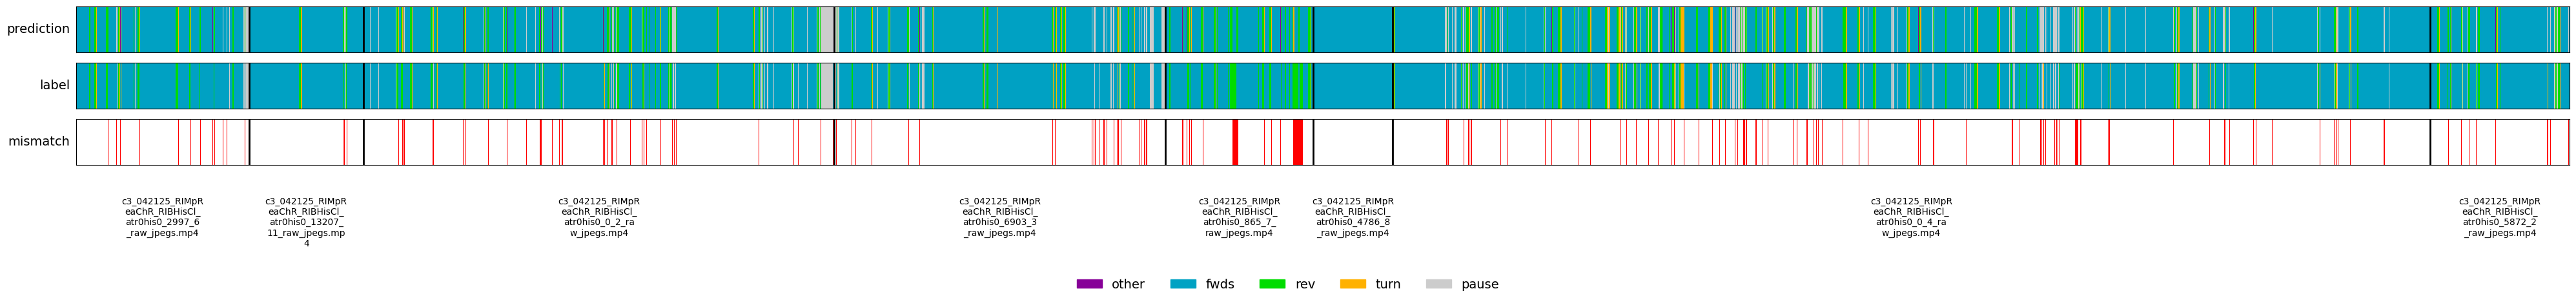

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import json
import matplotlib.cm as cm

# Assume you already have:
# logits: dict[str, np.ndarray of shape (T, num_classes)]
# all_data: dict[str, np.ndarray of shape (T,)]
# class_names: dict[int, str]

# Concatenate predictions and labels across all videos
video_names = list(logits.keys())

preds_list = []
targets_list = []
split_positions = []
start = 0

for name in video_names:
    pred = logits[name].argmax(1)
    label = np.array(all_data[name])

    preds_list.append(pred)
    targets_list.append(label)

    start += len(pred)
    split_positions.append(start)

split_positions = split_positions[:-1]

arr_pred = np.concatenate(preds_list)[None, :]
arr_label = np.concatenate(targets_list)[None, :]
arr_diff = (arr_pred != arr_label).astype(int)

# Prepare colormaps and labels
all_classes = sorted(set(np.unique(arr_pred)) | set(np.unique(arr_label)))
num_classes = len(all_classes)
base_cmap = cm.get_cmap('nipy_spectral')

# Skip dark colors near 0.0 — start sampling from 0.05 or 0.1
color_range = np.linspace(0.1, 1.0, num_classes)
colors = [base_cmap(val) for val in color_range]

cmap = ListedColormap(colors)
diff_cmap = ListedColormap(['white', 'red'])

labels = ['prediction', 'label', 'mismatch']
class_id_to_name = {int(k): v for k, v in json.load(open('/home/petr/home_datasets/all_configs/worm_behavior_dataset.json', 'r'))['class_names'].items()}
legend_elements = [mpatches.Patch(color=colors[i], label=class_id_to_name[i]) for i in all_classes]

# Plot
fig, axs = plt.subplots(3, 1, figsize=(40, 4), sharex=True)

for i, arr in enumerate([arr_pred, arr_label, arr_diff]):
    cmap_used = cmap if i < 2 else diff_cmap
    axs[i].imshow(arr, aspect='auto', cmap=cmap_used, interpolation='nearest')
    axs[i].set_yticks([0])
    axs[i].set_yticklabels([labels[i]], fontsize=14, rotation=0, va='center')
    axs[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    axs[i].tick_params(axis='y', which='both', left=False)
    for pos in split_positions:
        axs[i].axvline(pos, color='black', linewidth=2)

# Add video names centered under each segment
start = 0
for name in video_names:
    length = logits[name].shape[0]
    center = start + length // 2
    wrapped_name = '\n'.join([name[i:i+15] for i in range(0, len(name), 15)])
    axs[-1].text(center, 1.2, wrapped_name, ha='center', va='top', fontsize=10)  # Moved up slightly
    start += length

# Legend (moved further down)
fig.legend(
    handles=legend_elements,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.18),  # further down
    ncol=len(all_classes),
    fontsize=14,
    frameon=False
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.35)  # more space at bottom for legend
plt.show()


In [17]:
json.load(open('/home/petr/home_datasets/all_configs/worm_behavior_dataset.json', 'r'))['class_names']

{'0': 'other', '1': 'fwds', '2': 'rev', '3': 'turn', '4': 'pause'}

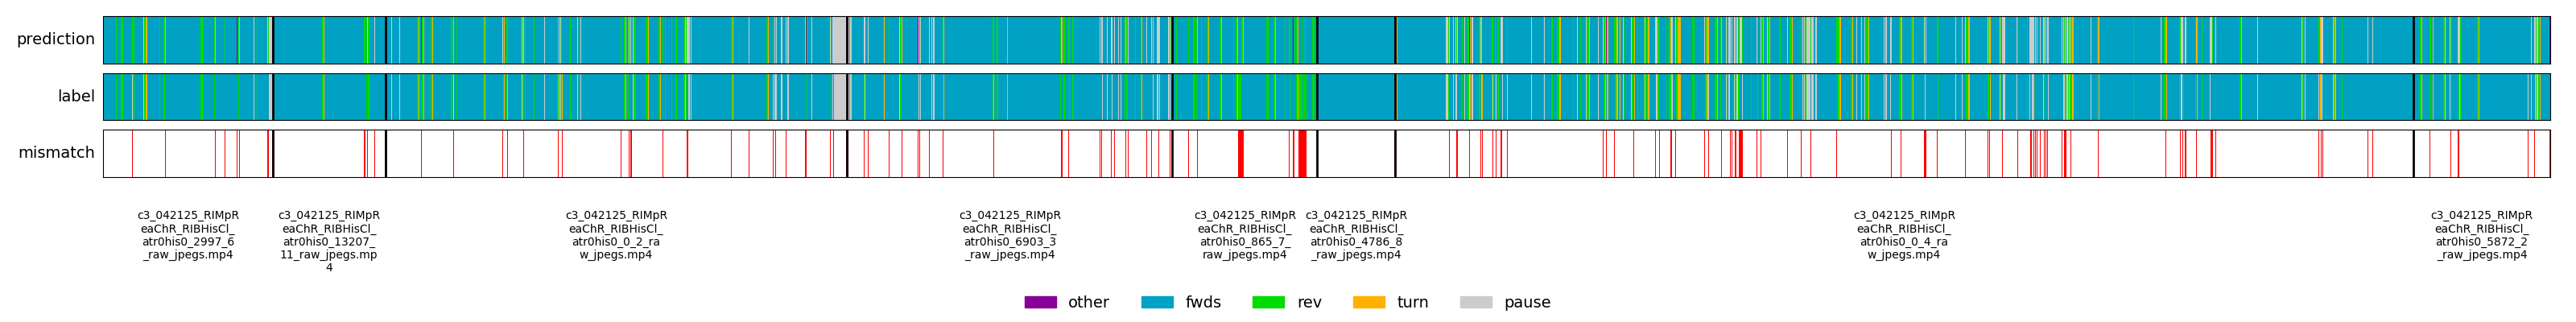

In [1]:
from metrics import generate_raster_plot
import json


generate_raster_plot(
    json.load(open('/home/petr/video_understanding/feral/answers/worms_2025-07-10_21-54-38.json', 'r')),
    64,
    json.load(open('/home/petr/home_datasets/all_configs/worm_behavior_dataset.json', 'r')),
    'val'
)

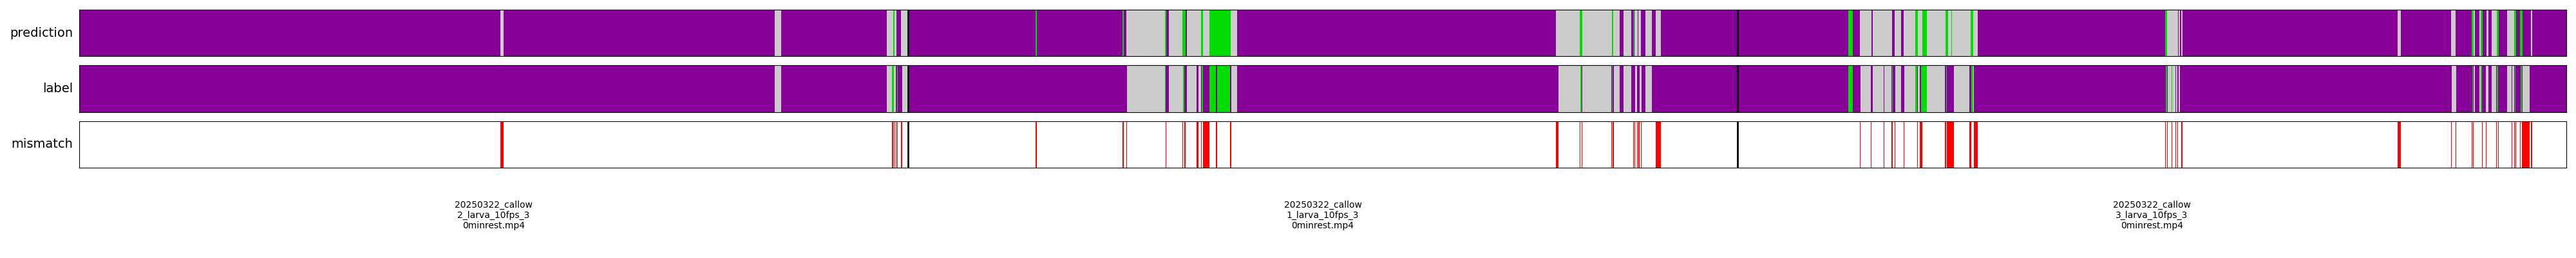

In [3]:
generate_raster_plot(
    json.load(open('/home/petr/video_understanding/feral/answers/ants_vjepa_h100_smaller_lr_2025-07-10_19-55-59.json', 'r')),
    64,
    json.load(open('/home/petr/home_datasets/all_configs/new_ant_labels.json', 'r')),
    'val'
)